In [9]:
import pandas as pd
import pandas as pd
import numpy as np
from transformers import pipeline
import torch
from tqdm import tqdm
import re
import math
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()

In [10]:
df = pd.read_csv("../data/responses_judged.csv")
df = df[df["prompt_id"].str.startswith("politics")]
df["user_id"] = df["context"]
df.loc[df["gpt_judge"].isna(), "gpt_judge"] = 0
df.loc[df["claude_judge"].isna(), "claude_judge"] = 0
df['polarity'] = df[['gpt_judge', 'claude_judge']].mean(axis=1)
df = df[["polarity", "user_id", "model", "prompt_id", "iteration"]]
mask = df["user_id"] == "zero-shot"
df.loc[mask, "user_id"] = "zero_shot" + df.loc[mask].index.astype(str)
df.head()

,polarity,user_id,model,prompt_id,iteration
0,0.75,zero_shot0,claude-sonnet-4-20250514,politics-abortion,24
1,1.00,zero_shot1,claude-sonnet-4-20250514,politics-abortion,25
2,1.00,zero_shot2,claude-sonnet-4-20250514,politics-abortion,26
3,1.00,zero_shot3,claude-sonnet-4-20250514,politics-abortion,27
4,0.25,zero_shot4,claude-sonnet-4-20250514,politics-abortion,28


In [11]:
participants = pd.read_csv("../data/participants.csv")
participants = participants[["user_id", "gender", "political_lean"]]
participants["is_man"] = (participants["gender"]=="man").astype(int)
participants["is_woman"] = (participants["gender"]!="man").astype(int)
participants["is_liberal"] = (participants["political_lean"].isin(["Liberal", "Very Liberal"])).astype(int)
participants["is_conservative"] =(participants["political_lean"].isin(["Moderate", "Conservative", "Very Conservative"])).astype(int)

participants = participants[["user_id", "is_man", "is_woman", "is_liberal", "is_conservative"]]
df = df.merge(participants, on="user_id", how="left")
df.head()

,polarity,user_id,model,prompt_id,iteration,is_man,is_woman,is_liberal,is_conservative
0,0.75,zero_shot0,claude-sonnet-4-20250514,politics-abortion,24,NaN,NaN,NaN,NaN
1,1.00,zero_shot1,claude-sonnet-4-20250514,politics-abortion,25,NaN,NaN,NaN,NaN
2,1.00,zero_shot2,claude-sonnet-4-20250514,politics-abortion,26,NaN,NaN,NaN,NaN
3,1.00,zero_shot3,claude-sonnet-4-20250514,politics-abortion,27,NaN,NaN,NaN,NaN
4,0.25,zero_shot4,claude-sonnet-4-20250514,politics-abortion,28,NaN,NaN,NaN,NaN


In [12]:
interactions = pd.read_csv("../data/interactions.csv")
interactions["context_length"] = interactions["tokens"]
interactions = interactions.groupby("user_id")["context_length"].max().reset_index()
df = df.merge(interactions, on="user_id", how="left")
interactions = pd.read_csv("../data/interactions.csv")
interactions["num_queries"] = interactions["tokens"]
interactions = interactions.groupby("user_id")["num_queries"].count().reset_index()
df = df.merge(interactions, on="user_id", how="left")
df.loc[df["context_length"].isna(), "context_length"] = 0
df.loc[df["num_queries"].isna(), "num_queries"] = 0
df["with_context"] = (df["context_length"]>0).astype(int)
df = df.fillna(0)
df.head()

,polarity,user_id,model,prompt_id,iteration,is_man,is_woman,is_liberal,is_conservative,context_length,num_queries,with_context
0,0.75,zero_shot0,claude-sonnet-4-20250514,politics-abortion,24,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.00,zero_shot1,claude-sonnet-4-20250514,politics-abortion,25,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.00,zero_shot2,claude-sonnet-4-20250514,politics-abortion,26,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.00,zero_shot3,claude-sonnet-4-20250514,politics-abortion,27,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.25,zero_shot4,claude-sonnet-4-20250514,politics-abortion,28,0.0,0.0,0.0,0.0,0.0,0.0,0


In [13]:
df["prompt_id"] = df["prompt_id"].str.replace("-", "_")
dummies = pd.get_dummies(df["prompt_id"]).astype(int)
df = pd.concat([df, dummies], axis=1)
df.head()

,polarity,user_id,model,prompt_id,iteration,is_man,is_woman,is_liberal,is_conservative,context_length,...,politics_abortion,politics_climate_change,politics_criminal_justice,politics_election_integrity,politics_healthcare,politics_higher_education,politics_immigration,politics_inflation,politics_taxes,politics_trade
0,0.75,zero_shot0,claude-sonnet-4-20250514,politics_abortion,24,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
1,1.00,zero_shot1,claude-sonnet-4-20250514,politics_abortion,25,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,1.00,zero_shot2,claude-sonnet-4-20250514,politics_abortion,26,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
3,1.00,zero_shot3,claude-sonnet-4-20250514,politics_abortion,27,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,0.25,zero_shot4,claude-sonnet-4-20250514,politics_abortion,28,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [14]:
df.to_csv("../data/regression/politics_polarity.csv", index=False)

In [17]:
df.loc[df["is_liberal"]==1, "polarity"].mean(), df.loc[df["context_length"]==0, "polarity"].mean()

(np.float64(0.34563492063492063), np.float64(0.36983695652173915))

# Plots

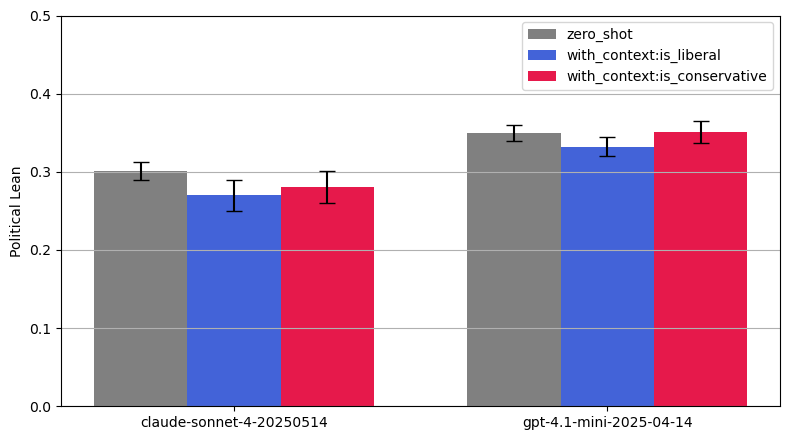

In [7]:
# -------------------- CONFIG --------------------
BASE_DIR = Path("../data/regression/")  # change if needed
MODEL_NAME1 = "claude-sonnet-4-20250514"
MODEL_NAME2 = "gpt-4.1-mini-2025-04-14"

INTERCEPT_NAMES = {"(Intercept)", "Intercept", "const", "_cons"}
MAN_NAME = "with_context:is_liberal"
WOMAN_NAME = "with_context:is_conservative"

# For your AITA topic dummies (e.g., aita_1ll3bu4, …). Adjust if needed.
TOPIC_REGEX = re.compile(r"^politics_[A-Za-z0-9]+$")

def load_model(model_name: str):
    coef_csv = BASE_DIR / f"politics_polarity_{model_name}.csv"
    vcov_csv = BASE_DIR / f"politics_polarity_{model_name}_vcov.csv"

    coef_df = pd.read_csv(coef_csv)
    vc_long = pd.read_csv(vcov_csv)

    # basic checks/types
    for col in ["coefficient_name", "coefficient_value", "standard_error"]:
        if col not in coef_df.columns:
            raise ValueError(f"{coef_csv} missing column: {col}")
    for col in ["term_i", "term_j", "cov"]:
        if col not in vc_long.columns:
            raise ValueError(f"{vcov_csv} missing column: {col}")

    coef_df["coefficient_value"] = pd.to_numeric(coef_df["coefficient_value"], errors="coerce")
    coef_df["standard_error"]    = pd.to_numeric(coef_df["standard_error"], errors="coerce")
    vc_long["cov"]               = pd.to_numeric(vc_long["cov"], errors="coerce")

    # order and Sigma
    coef_names = coef_df["coefficient_name"].tolist()
    name_to_idx = {t: i for i, t in enumerate(coef_names)}
    p = len(coef_names)
    Sigma = np.zeros((p, p), dtype=float)
    vc_filt = vc_long[
        vc_long["term_i"].isin(name_to_idx) & vc_long["term_j"].isin(name_to_idx)
    ]
    for _, r in vc_filt.iterrows():
        i = name_to_idx[r["term_i"]]; j = name_to_idx[r["term_j"]]
        Sigma[i, j] = r["cov"]
    Sigma = (Sigma + Sigma.T) / 2.0

    # if any diagonal missing, backfill with reported SE^2
    diag_zero = np.isclose(np.diag(Sigma), 0.0)
    if diag_zero.any():
        se_vec = coef_df["standard_error"].to_numpy(dtype=float)
        for k, missing in enumerate(diag_zero):
            if missing and np.isfinite(se_vec[k]) and se_vec[k] > 0:
                Sigma[k, k] = se_vec[k] ** 2

    # intercept
    intercept_name = None
    for cand in INTERCEPT_NAMES:
        if cand in name_to_idx:
            intercept_name = cand
            break
    if intercept_name is None:
        maybe = [n for n in coef_names if "intercept" in n.lower()]
        if maybe:
            intercept_name = maybe[0]
    if intercept_name is None:
        raise ValueError(f"Intercept not found in model {model_name}")

    beta0 = float(coef_df.loc[coef_df["coefficient_name"] == intercept_name, "coefficient_value"].iloc[0])

    def coef_or_zero(name):
        s = coef_df.loc[coef_df["coefficient_name"] == name, "coefficient_value"]
        return float(s.iloc[0]) if len(s) else 0.0

    delta_m = coef_or_zero(MAN_NAME)
    delta_w = coef_or_zero(WOMAN_NAME)

    # topic FEs
    topic_mask = coef_df["coefficient_name"].apply(lambda s: bool(TOPIC_REGEX.match(str(s))))
    topic_terms = coef_df.loc[topic_mask, "coefficient_name"].tolist()
    K = len(topic_terms)
    N = K + 1  # include omitted category as 0
    fe_avg = coef_df.loc[topic_mask, "coefficient_value"].sum() / N

    # point estimates
    zero_shot = beta0 + fe_avg
    with_man  = beta0 + delta_m + fe_avg
    with_woman= beta0 + delta_w + fe_avg

    # L vectors / SEs
    def L_vector(kind):
        L = np.zeros(p, dtype=float)
        L[name_to_idx[intercept_name]] = 1.0
        if kind == "liberal" and MAN_NAME in name_to_idx:
            L[name_to_idx[MAN_NAME]] = 1.0
        if kind == "conservative" and WOMAN_NAME in name_to_idx:
            L[name_to_idx[WOMAN_NAME]] = 1.0
        for t in topic_terms:
            L[name_to_idx[t]] = 1.0 / N
        return L

    def se_from_L(L):
        val = L @ Sigma @ L
        return float(np.sqrt(max(val, 0.0)))

    se_zero  = se_from_L(L_vector("zero_shot"))
    se_man   = se_from_L(L_vector("liberal"))
    se_woman = se_from_L(L_vector("conservative"))

    values = np.array([zero_shot, with_man, with_woman], dtype=float)
    errors = np.array([se_zero, se_man, se_woman], dtype=float)
    return values, errors

# -------------------- COMPUTE FOR BOTH MODELS --------------------
vals1, errs1 = load_model(MODEL_NAME1)
vals2, errs2 = load_model(MODEL_NAME2)

# -------------------- CLEAN GROUPED PLOT (no overlap) --------------------
labels = ["zero_shot", "with_context:is_liberal", "with_context:is_conservative"]
group_labels = [MODEL_NAME1, MODEL_NAME2]

centers = np.arange(len(group_labels))   # [0, 1]
n_bars = len(labels)                     # 3 conditions
group_width = 0.75                       # fraction of tick spacing to use
bar_w = group_width / n_bars             # width of each bar

# Offsets for the 3 bars within each group, centered on the tick
offsets = (np.arange(n_bars) - (n_bars - 1) / 2) * bar_w

plt.figure(figsize=(8, 4.5))

# Plot one condition at a time (consistent color per condition across models)
colors = ["#808080", "#4363d8", "#e6194b"]
for i, cond_label in enumerate(labels):
    heights = [vals1[i], vals2[i]]
    yerrs   = [errs1[i], errs2[i]]
    plt.bar(centers + offsets[i], heights, width=bar_w, yerr=yerrs, capsize=6, label=cond_label, color=colors[i])

plt.xticks(centers, group_labels)
plt.ylabel("Political Lean")
plt.legend()
plt.ylim(0, 0.5)
plt.gca().yaxis.grid(True, linestyle="-")  # optional readability
plt.tight_layout()
plt.show()


In [8]:
"""
Line plot of polarity vs num_queries for one model,
with separate lines for num_queries:is_liberal and num_queries:is_conservative.

Prediction for each line:
    yhat(x) = slope_term * x + avg(topic FE incl. omitted=0) [+ intercept if present]
SE of the mean prediction:
    SE(x) = sqrt( L(x) @ Sigma @ L(x) )
"""

# ============ CONFIG ============
BASE_DIR = Path("../data/regression/")  # change if needed
MODEL_NAME = "claude-sonnet-4-20250514"

# Range for num_queries
X_MIN, X_MAX, N_POINTS = 0, 160, 160

# Term names
LIB_TERM = "num_queries:is_liberal"
CON_TERM = "num_queries:is_conservative"
INTERCEPT_NAMES = {"(Intercept)", "Intercept", "const", "_cons"}

# Topic FE detection
TOPIC_REGEX = re.compile(r"^politics_[A-Za-z0-9_]+$")  # adjust if needed

# =================================

def load_model_artifacts(model_name: str):
    coef_csv = BASE_DIR / f"politics_polarity_{model_name}.csv"
    vcov_csv = BASE_DIR / f"politics_polarity_{model_name}_vcov.csv"

    coef_df = pd.read_csv(coef_csv)
    vc_long = pd.read_csv(vcov_csv)

    coef_df["coefficient_value"] = pd.to_numeric(coef_df["coefficient_value"], errors="coerce")
    coef_df["standard_error"]    = pd.to_numeric(coef_df["standard_error"], errors="coerce")
    vc_long["cov"]               = pd.to_numeric(vc_long["cov"], errors="coerce")

    coef_names = coef_df["coefficient_name"].tolist()
    name_to_idx = {t: i for i, t in enumerate(coef_names)}
    p = len(coef_names)
    Sigma = np.zeros((p, p), dtype=float)

    vc_filt = vc_long[
        vc_long["term_i"].isin(name_to_idx) & vc_long["term_j"].isin(name_to_idx)
    ]
    for _, r in vc_filt.iterrows():
        i = name_to_idx[r["term_i"]]; j = name_to_idx[r["term_j"]]
        Sigma[i, j] = r["cov"]
    Sigma = (Sigma + Sigma.T) / 2.0

    diag_zero = np.isclose(np.diag(Sigma), 0.0)
    if diag_zero.any():
        se_vec = coef_df["standard_error"].to_numpy(dtype=float)
        for k, missing in enumerate(diag_zero):
            if missing and np.isfinite(se_vec[k]) and se_vec[k] > 0:
                Sigma[k, k] = se_vec[k] ** 2

    # Intercept (if present)
    intercept_name = next((n for n in INTERCEPT_NAMES if n in name_to_idx), None)
    beta0 = float(coef_df.loc[coef_df["coefficient_name"] == intercept_name, "coefficient_value"].iloc[0]) if intercept_name else 0.0

    # Slopes
    if LIB_TERM not in name_to_idx or CON_TERM not in name_to_idx:
        raise ValueError(f"Missing {LIB_TERM} or {CON_TERM} in coefficients.")

    beta_lib = float(coef_df.loc[coef_df["coefficient_name"] == LIB_TERM, "coefficient_value"].iloc[0])
    beta_con = float(coef_df.loc[coef_df["coefficient_name"] == CON_TERM, "coefficient_value"].iloc[0])

    # Topic FE average (including omitted)
    topic_mask = coef_df["coefficient_name"].apply(lambda s: bool(TOPIC_REGEX.match(str(s))))
    topic_terms = coef_df.loc[topic_mask, "coefficient_name"].tolist()
    K = len(topic_terms)
    N = K + 1
    fe_avg = coef_df.loc[topic_mask, "coefficient_value"].sum() / N

    return {
        "coef_names": coef_names,
        "name_to_idx": name_to_idx,
        "Sigma": Sigma,
        "beta0": beta0,
        "beta_lib": beta_lib,
        "beta_con": beta_con,
        "topic_terms": topic_terms,
        "N": N,
        "intercept_name": intercept_name,
        "fe_avg": fe_avg,
    }

def predict_curve(artifacts, term_name, x_grid: np.ndarray):
    """Return yhat(x), SE(x) for mean prediction line for given term_name."""
    beta0 = artifacts["beta0"]
    fe_avg = artifacts["fe_avg"]
    N = artifacts["N"]
    Sigma = artifacts["Sigma"]
    names = artifacts["coef_names"]
    idx = artifacts["name_to_idx"]
    topic_terms = artifacts["topic_terms"]

    p = len(names)
    base_L = np.zeros(p, dtype=float)
    if artifacts["intercept_name"]:
        base_L[idx[artifacts["intercept_name"]]] = 1.0
    for t in topic_terms:
        base_L[idx[t]] = 1.0 / N

    term_idx = idx[term_name]
    beta_term = artifacts["beta_lib"] if term_name == LIB_TERM else artifacts["beta_con"]

    yhat = beta0 + fe_avg + beta_term * x_grid
    se = np.empty_like(x_grid, dtype=float)

    for i, x in enumerate(x_grid):
        L = base_L.copy()
        L[term_idx] = x
        val = L @ Sigma @ L
        se[i] = float(np.sqrt(max(val, 0.0)))

    return yhat, se

# ---- Load model ----
art = load_model_artifacts(MODEL_NAME)

# ---- X grid ----
x_grid = np.linspace(X_MIN, X_MAX, N_POINTS)

# ---- Predictions ----
y_lib, se_lib = predict_curve(art, LIB_TERM, x_grid)
y_con, se_con = predict_curve(art, CON_TERM, x_grid)

# ---- Plot ----
plt.figure(figsize=(4, 4))

line_lib, = plt.plot(x_grid, y_lib, label="is_liberal", color="#4363d8")
plt.fill_between(x_grid, y_lib - 1.96*se_lib, y_lib + 1.96*se_lib, alpha=0.2, color=line_lib.get_color())

line_con, = plt.plot(x_grid, y_con, label="is_conservative", color="#e6194b")
plt.fill_between(x_grid, y_con - 1.96*se_con, y_con + 1.96*se_con, alpha=0.2, color=line_con.get_color())

plt.xlabel("Number of Queries")
plt.ylabel("Political Lean")
plt.ylim([0, 0.5])
plt.xlim([0, 160])
plt.legend()
plt.gca().yaxis.grid(True, linestyle="-")
plt.gca().xaxis.grid(True, linestyle="-")
plt.tight_layout()
plt.show()


ValueError: Missing num_queries:is_liberal or num_queries:is_conservative in coefficients.